
# <font color=red> <u>ML_CUP</u>: <br> &#x2022; **Support Vector Machine: *SVR model*  - with *grid_search*  </font>** <br>

The SVR(Support Vector Regression) model select the **best decision boundary** to separate the data in the hyperplane.
SVM represents the decision boundary using a subset of the training examples, known as the **support vectors**.

init del cup dataset:

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from numpy.linalg import norm
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer

from utils_cup_svm_svr import * #custom module  works with 3.9.xx


#UTILITIES FUNCTIONS
def get_cup_df(num, train=True):
    data_type = "TR.csv" if train else "TS.csv"
    path = cup_path+str(num)+'.'+data_type

    columns = ["id", "a1", "a2", "a3", "a4", "a5", "a6","a7","a8","a9","output1","output2"]
    # skipping first 7 rows as they are comments and not actual data
    df = pd.read_csv(path, names=columns, delimiter=" ")

    df = df.drop('id', axis='columns')
    #df = df.drop("monk_id", axis='columns')
    return pd.get_dummies(df, columns=df.columns[1:])


def MEE(y_true,y_pred,mean=True):
    assert y_pred.shape == y_true.shape, 'x and y must have same shape'
    length = y_pred.shape[0] #lunghezza RIGHE
    total = 0

    for i in range(length):
        term_one = abs( y_pred[i][0] - y_true[i][0] )
        term_two = abs( y_pred[i][1] - y_true[i][1] )
     
        result_in_sqrt = (term_one ** 2) + (term_two ** 2)
        result_sqrt = math.sqrt(result_in_sqrt)

        total = total + result_sqrt

    return total/length

def print_stats_gs(grid_search):
    print('Best setting parameters: ',grid_search.best_params_)
    print('Best SCORE di MEE: ',grid_search.best_score_)
    print('\nMEDIO VALORE MEE su CV: ', grid_search.cv_results_['mean_test_score'][0], 
    '\nStandard Deviation (std) of this setting: ', grid_search.cv_results_['std_test_score'][0])
    
def get_mae_mee_mse_from_gridsearch(grid_search,Y,Y_pred):
    mee = MEE(Y,Y_pred)
    #accuracy = accuracy_score(Y_internal_tr,Y_pred)
    mae = mean_absolute_error(Y,Y_pred)
    mse = np.sqrt(mean_squared_error(Y, Y_pred))

    return mae, mse, mee


custom_mee_scorer = make_scorer(MEE,greater_is_better=False)

------

## Dataset preparation:

In [2]:
cup_path = 'datasets/ML-CUP22-'

columns = ["id", "a1", "a2", "a3", "a4", "a5", "a6","a7","a8","a9","output1","output2"]
df_cup_tr = pd.read_csv(cup_path+"TR.csv",comment='#', index_col=0, sep=',',names=columns) #12 colonne, di cui 1 id e ultime 2 output
df_cup_tr.head()
df_cup_tr.shape

X = df_cup_tr.iloc[:, 0:9].values
Y = df_cup_tr.iloc[:, 9:11].values

#design set - 80% training, 20% testing
X_internal_tr, X_int_test, Y_internal_tr, Y_int_test = train_test_split(X, Y, test_size=0.2, train_size=0.8,random_state=72,shuffle=True)

# **<font color=#33ECFF> 1. Kernel 'RBF' <br> &#x2022; PARAMS: C, gamma,epsilon<font>**

In [3]:
kernel=['rbf']
C_list=[0.1,1,10,100,1000]
gamma_list= ["auto", "scale"]
epsilon_list=[0.001]

svr_model= SVR()

param_grid = {'estimator__kernel' : kernel,
            'estimator__C' : C_list,
            'estimator__gamma' : ('auto','scale'),
            'estimator__epsilon': epsilon_list}

grid_search = GridSearchCV(MultiOutputRegressor(svr_model), 
                        param_grid = param_grid,
                        n_jobs=-1,
                        scoring=custom_mee_scorer,
                        verbose=0)


grid_search.fit(X_internal_tr, Y_internal_tr)
Y_pred = grid_search.predict(X_internal_tr)

print('Best setting parameters: ',grid_search.best_params_)
print('Best MEE validation score: ',grid_search.best_score_)
print('\nVERO MEE - Mean of this setting: ', grid_search.cv_results_['mean_test_score'][0], '\nStandard Deviation (std) of this setting: ', grid_search.cv_results_['std_test_score'][0])

Best setting parameters:  {'estimator__C': 10, 'estimator__epsilon': 0.001, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}
Best MEE validation score:  -1.4653643394886358

VERO MEE - Mean of this setting:  -1.9740710010349978 
Standard Deviation (std) of this setting:  0.126259645754078


-----

## **<font color=#33ECFF> 1.1.1 - RBF: <u>Results</u> HP e wrt <u>VALIDATION SET</u> by GridSearchCV</u></font>**

In [4]:
col = ["KERNEL","C","EPS","GAMMA","BEST MEE_Validation","MEAN MEE_Validation","STD_Validation"]

best_C, best_eps, best_gamma = extract_best_hp_rbf(grid_search)
best_kernel = grid_search.best_params_["estimator__kernel"]
row = [best_kernel,best_C,best_eps,best_gamma,grid_search.best_score_,grid_search.cv_results_['mean_test_score'][0],grid_search.cv_results_['std_test_score'][0]]

rbf_df_best_res_validation = pd.DataFrame(columns=col)
rbf_df_best_res_validation.loc[len(rbf_df_best_res_validation)] = row

print("BEST HYPERPARAMETERS SETTINGS AND MEE in Validation:")
rbf_df_best_res_validation

BEST HYPERPARAMETERS SETTINGS AND MEE in Validation:


,KERNEL,C,EPS,GAMMA,BEST MEE_Validation,MEAN MEE_Validation,STD_Validation
0,rbf,10,0.001,auto,-1.465364,-1.974071,0.12626


## **<font color=#33ECFF> 1.1.2 - RBF: METRICS wrt <u>TRAINING SET</u></font>**

We have also investigated the behaviour of the model on the training set:

In [5]:

mee = MEE(Y_pred,Y_internal_tr) #(y_test,y_pred)
mae = mean_absolute_error(Y_internal_tr,Y_pred)
mse = np.sqrt(mean_squared_error(Y_internal_tr, Y_pred))
metrics_results = [mae, mse, mee]

best_C, best_eps, best_gamma = extract_best_hp_rbf(grid_search)
best_kernel = grid_search.best_params_["estimator__kernel"]

new_res = [best_kernel,best_C,best_eps,best_gamma,mae,mse,mee]
new_col = ["KERNEL","C","EPS","GAMMA","MAE","MSE","MEE"]

#df.loc[len(df)] = list_row - esempio di come si aggiunge una riga ad un df   
df_best_grid_all_param = pd.DataFrame(columns=new_col)
df_best_grid_all_param.loc[len(df_best_grid_all_param)] = new_res

print("BEST HYPERPARAMETERS SETTINGS AND METRICS IN SVR MODEL by GridSearchCV between all parameters provided:")
df_best_grid_all_param


BEST HYPERPARAMETERS SETTINGS AND METRICS IN SVR MODEL by GridSearchCV between all parameters provided:


,KERNEL,C,EPS,GAMMA,MAE,MSE,MEE
0,rbf,10,0.001,auto,0.702076,1.162326,1.167264


 # **<font color=#33ECFF> 1.2 RBF Plot: Investigation when varying C on *training set* </font>**

We investigated the behaviour of the model when varying C.

In [6]:
def run_gs_on_C_rbf(kernel,C_list,epsilon_list,gamma_list):
    svr_model= SVR()
    new_col = ["C","EPS","GAMMA",   "MAE","MSE","MEE"]
    df_temp = pd.DataFrame(columns=new_col)

    for c_val in C_list:
        list = [c_val]
        param_grid = {'estimator__kernel' : kernel,
            'estimator__C' : list,
            'estimator__gamma' : ('auto','scale'),
            'estimator__epsilon': epsilon_list}

        grid_search = GridSearchCV(MultiOutputRegressor(svr_model), 
                        param_grid = param_grid,
                        n_jobs=2,
                        scoring=custom_mee_scorer,
                        verbose=0)

        grid_search.fit(X_internal_tr, Y_internal_tr)
        Y_pred = grid_search.predict(X_internal_tr)

        best_C, best_eps, best_gamma = extract_best_hp_rbf(grid_search)
        mae,mse,mee = get_mae_mee_mse_from_gridsearch(grid_search,Y=Y_internal_tr,Y_pred=Y_pred)

        new_res = [best_C,best_eps,best_gamma,mae,mse,mee]
        df_temp.loc[len(df_temp)] = new_res
    
    return df_temp


#EXECUTION
C_values_list=[0.1,1,10,100,1000]
df_on_C_rbf = run_gs_on_C_rbf(kernel=["rbf"],C_list=C_values_list, epsilon_list=epsilon_list,gamma_list=gamma_list)

In [7]:
df_on_C_rbf.sort_values(by=['MEE'])

,C,EPS,GAMMA,MAE,MSE,MEE
4,1000.0,0.001,auto,0.322617,0.787833,0.556980
3,100.0,0.001,auto,0.534217,1.015934,0.903183
2,10.0,0.001,auto,0.702076,1.162326,1.167264
1,1.0,0.001,auto,0.841865,1.279638,1.370884
0,0.1,0.001,auto,1.111286,1.632957,1.827651


,C,EPS,GAMMA,MAE,MSE,MEE
0,0.1,0.001,auto,1.111286,1.632957,1.827651


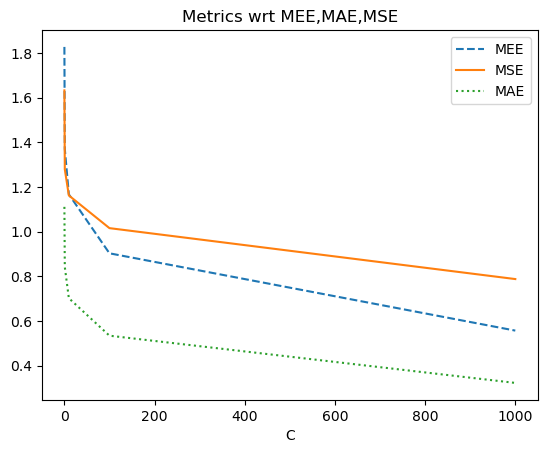

In [8]:
ax = df_on_C_rbf.plot(x='C', y='MEE', linestyle='--', title="Metrics wrt MEE,MAE,MSE")
df_on_C_rbf.plot(ax=ax,x='C', y='MSE')
df_on_C_rbf.plot(ax=ax,x='C', y='MAE', linestyle='dotted')
df_on_C_rbf.sort_values(by=['C']).head(1)

# **<font color=#33ECFF> 2. Kernel 'Poly' <br> &#x2022; PARAMS: C,epsilon, coef0, degree<font>**

In [9]:
kernel=['poly']
C_list=[0.1,0.5,1,2,5]
epsilon_list=[0.01]
coeff_list=[0.5,1.0,1.5]
degree_list = [2,3,4,5]

svr_model= SVR()
param_grid = {'estimator__kernel' : kernel,
            'estimator__C' : C_list,
            'estimator__epsilon': epsilon_list,
            'estimator__coef0': coeff_list,
            'estimator__degree': degree_list}

grid_search_poly = GridSearchCV(MultiOutputRegressor(svr_model), 
                        param_grid = param_grid,
                        n_jobs=2,
                        scoring=custom_mee_scorer,
                        verbose=0)

grid_search_poly.fit(X_internal_tr, Y_internal_tr)
Y_pred_poly = grid_search_poly.predict(X_internal_tr)

print_stats_gs(grid_search=grid_search_poly)

Best setting parameters:  {'estimator__C': 0.1, 'estimator__coef0': 1.5, 'estimator__degree': 5, 'estimator__epsilon': 0.01, 'estimator__kernel': 'poly'}
Best SCORE di MEE:  -1.5073710364560526

MEDIO VALORE MEE su CV:  -1.8384955770924378 
Standard Deviation (std) of this setting:  0.0788396672571087


## **<font color=#33ECFF> 2.1.1 - POLY: <u>Results</u> HP e wrt <u>VALIDATION SET</u> by GridSearchCV</u></font>**

In [10]:
col = ["KERNEL","C","EPS","COEF0","DEGREE","BEST MEE","MEE_Validation","STD_Validation"]
best_C, best_coef0, best_degree,best_eps = extract_best_hp_poly(grid_search_poly)
row = ['poly',best_C,best_eps,best_coef0, best_degree,grid_search_poly.best_score_,grid_search_poly.cv_results_['mean_test_score'][0],grid_search_poly.cv_results_['std_test_score'][0]]

poly_df_best_res_validation = pd.DataFrame(columns=col)
poly_df_best_res_validation.loc[len(rbf_df_best_res_validation)] = row

print("BEST HYPERPARAMETERS SETTINGS AND MEE in Validation:")
poly_df_best_res_validation

BEST HYPERPARAMETERS SETTINGS AND MEE in Validation:


,KERNEL,C,EPS,COEF0,DEGREE,BEST MEE,MEE_Validation,STD_Validation
1,poly,0.1,0.01,1.5,5,-1.507371,-1.838496,0.07884


## **<font color=#33ECFF> 2.1.2 - RBF: Metrics wrt TRAINING SET</font>**

In [11]:
best_C, best_coef0, best_degree,best_eps = extract_best_hp_poly(grid_search_poly)
mae,mse,mee = get_mae_mee_mse_from_gridsearch(grid_search_poly,Y=Y_internal_tr,Y_pred=Y_pred_poly)

new_res = [best_C,best_eps,best_coef0,best_degree,mae,mse,mee]
new_col = ["C","EPS","COEF0","DEGREE","MAE","MSE","MEE"]
    
df_best_grid_poly = pd.DataFrame(columns=new_col)
df_best_grid_poly.loc[len(df_best_grid_poly)] = new_res

df_best_grid_poly

,C,EPS,COEF0,DEGREE,MAE,MSE,MEE
0,0.1,0.01,1.5,5.0,0.755731,1.212558,1.246362


 # **<font color=#33ECFF> 2.2 POLY Plot: Investigation when varying C on *training set* </font>**

In [12]:
def run_gs_on_C_poly(kernel,C_list,epsilon_list,coeff_list,degree_list):
    svr_model= SVR()
    new_col = ["C","EPS","COEF0","DEGREE","MAE","MSE","MEE"]  
    df_temp = pd.DataFrame(columns=new_col)

    for c_val in C_list:
        list = [c_val]
        param_grid = {'estimator__kernel' : kernel,
                    'estimator__C' : list,
                    'estimator__epsilon': epsilon_list,
                    'estimator__coef0': coeff_list,
                    'estimator__degree': degree_list}

        grid_search_poly = GridSearchCV(MultiOutputRegressor(svr_model), 
                                param_grid = param_grid,
                                n_jobs=2,
                                scoring=custom_mee_scorer,
                                verbose=0)

        grid_search_poly.fit(X_internal_tr, Y_internal_tr)
        Y_pred_poly = grid_search_poly.predict(X_internal_tr)

        best_C, best_coef0, best_degree,best_eps = extract_best_hp_poly(grid_search_poly)

        mae,mse,mee = get_mae_mee_mse_from_gridsearch(grid_search_poly,Y=Y_internal_tr,Y_pred=Y_pred_poly)

        new_res = [best_C,best_eps,best_coef0,best_degree,mae,mse,mee]
        df_temp.loc[len(df_temp)] = new_res
    
    return df_temp


#EXECUTION
C_values_list=[0.1,0.5,1,2,5]
epsilon_list=[0.01]
coeff_list=[0.5,1.0,1.5]
degree_list = [2,3,4,5]

df_on_C_poly = run_gs_on_C_poly(kernel=['poly'],C_list=C_values_list, epsilon_list=epsilon_list,coeff_list=coeff_list,degree_list=degree_list)
df_on_C_poly.sort_values(by=['MEE'])

,C,EPS,COEF0,DEGREE,MAE,MSE,MEE
4,5.0,0.01,0.5,4.0,0.695579,1.157205,1.150079
3,2.0,0.01,0.5,4.0,0.740561,1.200557,1.222970
2,1.0,0.01,1.0,4.0,0.750281,1.205057,1.237086
0,0.1,0.01,1.5,5.0,0.755731,1.212558,1.246362
1,0.5,0.01,1.0,4.0,0.783202,1.236442,1.290274


,C,EPS,COEF0,DEGREE,MAE,MSE,MEE
0,0.1,0.01,1.5,5.0,0.755731,1.212558,1.246362


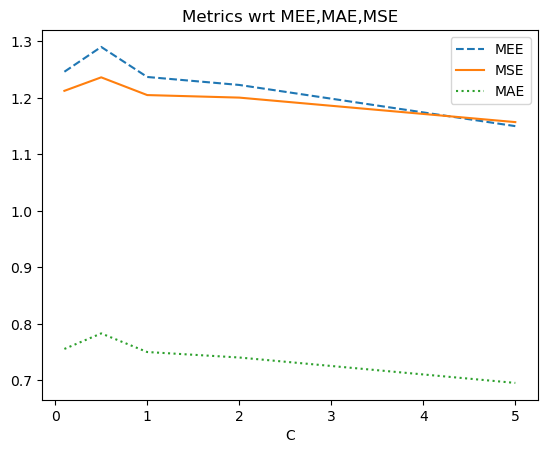

In [13]:
ax = df_on_C_poly.plot(x='C', y='MEE', linestyle='--', title="Metrics wrt MEE,MAE,MSE")
df_on_C_poly.plot(ax=ax,x='C', y='MSE')
df_on_C_poly.plot(ax=ax,x='C', y='MAE', linestyle='dotted')
df_on_C_poly.sort_values(by=['C']).head(1)

# **<font color=#33ECFF> 3. Kernel 'Sigmoid' <br> &#x2022; PARAMS: C, gamma, epsilon, coef0<font>**

In [14]:
kernel=['sigmoid']
C_list=[0.0001,0.001,0.01,0.1,1]
gamma_list= ["auto", "scale"]
epsilon_list=[0.001]
coeff_list=[1.0,2.0,3.0]

svr_model= SVR()
param_grid = {'estimator__kernel' : kernel,
            'estimator__C' : C_list,
            'estimator__gamma' : gamma_list,
            'estimator__epsilon': epsilon_list,
            'estimator__coef0': coeff_list}

grid_search_sig = GridSearchCV(MultiOutputRegressor(svr_model), 
                        param_grid = param_grid,
                        n_jobs=2,
                        scoring=custom_mee_scorer,
                        verbose=0)

grid_search_sig.fit(X_internal_tr, Y_internal_tr)
Y_pred_sig = grid_search_sig.predict(X_internal_tr)

print_stats_gs(grid_search=grid_search_sig)

Best setting parameters:  {'estimator__C': 0.1, 'estimator__coef0': 2.0, 'estimator__epsilon': 0.001, 'estimator__gamma': 'auto', 'estimator__kernel': 'sigmoid'}
Best SCORE di MEE:  -4.428738561652233

MEDIO VALORE MEE su CV:  -7.102960010356881 
Standard Deviation (std) of this setting:  0.12847136103246415


## **<font color=#33ECFF> 3.1.1 - SIGMOID: <u>Results</u> HP e wrt <u>VALIDATION SET</u> by GridSearchCV</u></font>**

In [15]:
col = ["KERNEL","C","COEF0","EPS","GAMMA","BEST MEE","MEE_Validation","STD_Validation"]

best_C, best_coef0, best_eps,best_gamma = extract_best_hp_sig(grid_search_sig)
row = ['sig',best_C, best_coef0, best_eps, best_gamma,grid_search_sig.best_score_,grid_search_sig.cv_results_['mean_test_score'][0],grid_search_sig.cv_results_['std_test_score'][0]]
  
sig_df_best_res_validation = pd.DataFrame(columns=col)
sig_df_best_res_validation.loc[len(rbf_df_best_res_validation)] = row

print("BEST HYPERPARAMETERS SETTINGS AND MEE in Validation:")
sig_df_best_res_validation

BEST HYPERPARAMETERS SETTINGS AND MEE in Validation:


,KERNEL,C,COEF0,EPS,GAMMA,BEST MEE,MEE_Validation,STD_Validation
1,sig,0.1,2.0,0.001,auto,-4.428739,-7.10296,0.128471


## **<font color=#33ECFF> 3.1.2 - Sigmoid: Metrics wrt TRAINING SET</font>**

In [16]:
def extract_best_hp_sig(grid_search):
    array = []
    values = grid_search.best_params_.values()
    for v in values:
        array.append(v)
    best_C, best_coef0, best_eps, best_gamma  = array[0], array[1], array[2], array[3]
    return best_C, best_coef0, best_eps, best_gamma


best_C, best_coef0, best_eps, best_gamma = extract_best_hp_sig(grid_search_sig)
mae,mse,mee = get_mae_mee_mse_from_gridsearch(grid_search_sig,Y=Y_internal_tr,Y_pred=Y_pred_sig)

new_res = [best_C, best_coef0, best_eps, best_gamma,mae,mse,mee]
new_col = ["C","COEF0","EPS","GAMMA","MAE","MSE","MEE"]
    
df_best_grid_sig = pd.DataFrame(columns=new_col)
df_best_grid_sig.loc[len(df_best_grid_sig)] = new_res

df_best_grid_sig

,C,COEF0,EPS,GAMMA,MAE,MSE,MEE
0,0.1,2.0,0.001,auto,2.735638,3.563087,4.514993


----------

 # **<font color=#33ECFF> 2.2 SIGMOID Plot: Investigation when varying C on *training set* </font>**

In [17]:
def run_gs_on_C_sig(kernel,C_list,epsilon_list,coeff_list):
    svr_model= SVR()
    new_col = ["C","COEF0","EPS","GAMMA","MAE","MSE","MEE"]
    df_temp = pd.DataFrame(columns=new_col)

    for c_val in C_list:
        list = [c_val]
        param_grid = {'estimator__kernel' : kernel,
                'estimator__C' : list,
                'estimator__gamma' : ('auto','scale'),
                'estimator__epsilon': epsilon_list,
                'estimator__coef0': coeff_list}

        grid_search_sig = GridSearchCV(MultiOutputRegressor(svr_model), 
                                param_grid = param_grid, 
                                n_jobs=2,
                                scoring=custom_mee_scorer,
                                verbose=0)

        grid_search_sig.fit(X_internal_tr, Y_internal_tr)
        Y_pred_sig = grid_search_sig.predict(X_internal_tr)

        best_C, best_coef0, best_eps, best_gamma = extract_best_hp_sig(grid_search_sig)
        mae,mse,mee = get_mae_mee_mse_from_gridsearch(grid_search_sig,Y=Y_internal_tr,Y_pred=Y_pred_sig)
        
        new_res = [best_C, best_coef0, best_eps, best_gamma,mae,mse,mee]
        df_temp.loc[len(df_temp)] = new_res
    
    print("ok")
    return df_temp


#EXECUTION FUNCTION
C_values_list = [0.00001,0.0001,0.001,0.01,0.1,1]
gamma_list= ["auto", "scale"]
epsilon_list=[0.001]
coeff_list=[1.0,2.0,3.0]

df_on_C_sig = run_gs_on_C_sig(kernel=["sigmoid"],C_list=C_values_list, epsilon_list=epsilon_list,coeff_list=coeff_list)

ok


In [18]:
df_on_C_sig.sort_values(by=['MEE'])

,C,COEF0,EPS,GAMMA,MAE,MSE,MEE
4,0.10000,2.0,0.001,auto,2.735638,3.563087,4.514993
3,0.01000,1.0,0.001,scale,2.792786,3.721787,4.628745
5,1.00000,3.0,0.001,auto,3.245656,4.053974,5.202266
2,0.00100,1.0,0.001,scale,4.190359,5.355859,6.822993
1,0.00010,1.0,0.001,scale,4.360757,5.564589,7.089646
0,0.00001,1.0,0.001,scale,4.378303,5.586233,7.116838


,C,COEF0,EPS,GAMMA,MAE,MSE,MEE
0,0.00001,1.0,0.001,scale,4.378303,5.586233,7.116838


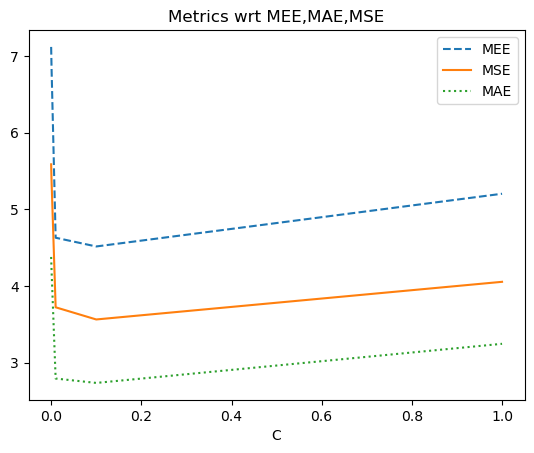

In [19]:
ax = df_on_C_sig.plot(x='C', y='MEE', linestyle='--', title="Metrics wrt MEE,MAE,MSE")
df_on_C_sig.plot(ax=ax,x='C', y='MSE')
df_on_C_sig.plot(ax=ax,x='C', y='MAE', linestyle='dotted')
df_on_C_sig.sort_values(by=['C']).head(1)